In [1]:
import numpy as np
import pandas as pd

In [2]:
import nltk
import vaderSentiment as vd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from nrclex import NRCLex

In [3]:
from textblob import TextBlob

In [36]:
data = pd.read_csv("tweets.csv")
data.shape

(56571, 9)

In [27]:
data.isnull().sum()

id           0
text         0
isRetweet    0
isDeleted    0
device       0
favorites    0
retweets     0
date         0
isFlagged    0
dtype: int64

In [37]:
#sentiment analysis with neg, neu, pos

#add compound sentiment score to dataframe
#each entry of compound score include 'neg', 'neu', 'pos', each score ranges in [0,1]
#'compound' score in sequence from [-1,1], as initial opinion
#data type as np array with 4 elements
#divided to be 2 group of elements, one with negativity&neutrality&positivity score, the other one with compound sentiment score

neg_neu_pos = []
compound_score = []
sent_analyzer = SentimentIntensityAnalyzer()
for i in range(56571):
    sentence = data['text'].iloc[i]
    overall=sent_analyzer.polarity_scores(sentence)
    compound=overall["compound"]
    compound_score.append(compound)
    del overall["compound"]
    score=np.array(list(overall.values()))
    neg_neu_pos.append(score)

data['neg_neu_pos'] = neg_neu_pos
data['compound_score'] = compound_score
data.head(5)

#didn't find the buildin algorithm for calculating compound sentiment score
#Using the compound score can be enough to determine the underlying sentiment of a text, because for:
#a positive sentiment, compound ≥ 0.05
#a negative sentiment, compound ≤ -0.05
#a neutral sentiment, the compound is between [-0.05, 0.05]

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,neg_neu_pos,compound_score
0,9.845500e+16,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,8/2/2011 18:07,f,"[0.231, 0.598, 0.171]",-0.1779
1,1.234650e+18,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,3/3/2020 1:34,f,"[0.0, 0.553, 0.447]",0.9792
2,1.218010e+18,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,1/17/2020 3:22,f,"[0.0, 1.0, 0.0]",0.0000
3,1.304880e+18,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,9/12/2020 20:10,f,"[0.294, 0.706, 0.0]",-0.9551
4,1.218160e+18,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,1/17/2020 13:13,f,"[0.0, 0.857, 0.143]",0.5413


In [38]:
#add sentiment score
#each entry is an np array of 8 elements, which are 'fear','anger','anticipation','trust','surprise','sadness','disgust','joy'
#each sentiment score ranges in {0,1,2,3,4}

#negative emotion can decrease trust

sentiment_score = []
conf_bound = []
keys_to_check = ['fear','anger','anticipation','trust','surprise','sadness','disgust','joy']

sentiments = {key: [] for key in keys_to_check}

for i in range(56571):
    sentence = data['text'].iloc[i]
    text_object = NRCLex(sentence)
    scores = text_object.raw_emotion_scores

    # Append the score for each sentiment, or 0 if the sentiment is not present
    for sentiment in keys_to_check:
        sentiments[sentiment].append(scores.get(sentiment, 0))

# Add each sentiment as a new column to the DataFrame
for sentiment in keys_to_check:
    data[sentiment] = sentiments[sentiment]

data.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,neg_neu_pos,compound_score,fear,anger,anticipation,trust,surprise,sadness,disgust,joy
0,9.845500e+16,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,8/2/2011 18:07,f,"[0.231, 0.598, 0.171]",-0.1779,0,0,0,0,0,0,0,0
1,1.234650e+18,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,3/3/2020 1:34,f,"[0.0, 0.553, 0.447]",0.9792,0,0,2,3,2,0,0,4
2,1.218010e+18,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,1/17/2020 3:22,f,"[0.0, 1.0, 0.0]",0.0000,2,1,1,0,0,0,0,0
3,1.304880e+18,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,9/12/2020 20:10,f,"[0.294, 0.706, 0.0]",-0.9551,3,2,0,2,1,2,1,0
4,1.218160e+18,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,1/17/2020 13:13,f,"[0.0, 0.857, 0.143]",0.5413,0,0,1,1,0,0,0,1


In [39]:
# the following installations are required
# python -m textblob.download_corpora
# python -m spacy download en_core_web_sm

polar_sub_score = []
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
for i in range(56571):
    sentence = data['text'].iloc[i]
    doc=nlp(sentence)
    #polarity: [-1,1], -1 for negative statement, 1 for positive statement
    #subjectivity: [0,1], 0 for objective/factual statement, 1 for subjective/personal statement
    p=doc._.blob.sentiment_assessments.polarity
    s=doc._.blob.sentiment_assessments.subjectivity
    polar_sub={'polarity':p, 'subjectivity':s}
    score=np.array(list(polar_sub.values()))
    polar_sub_score.append(score)

len(polar_sub_score)
data['polar_sub_score'] = polar_sub_score
data.head(3)


#doc = nlp(text)
#polarity: [-1,1], -1 for negative statement, 1 for positive statement
#subjectivity: [0,1], 0 for objective/factual statement, 1 for subjective/personal statement

#doc._.blob.polarity                            # Polarity: -0.125
#doc._.blob.subjectivity                        # Subjectivity: 0.9
#p=doc._.blob.sentiment_assessments.polarity
#s=doc._.blob.sentiment_assessments.subjectivity
#polar_subj={'polarity':p, 'subjectivity':s}
#print(s)
#print(doc._.blob.sentiment_assessments.polarity)
#print(doc._.blob.sentiment_assessments.subjectivity)
# Assessments: [(['really', 'horrible'], -1.0, 1.0, None), (['worst', '!'], -1.0, 1.0, None), (['really', 'good'], 0.7, 0.6000000000000001, None), (['happy'], 0.8, 1.0, None)]
#type(doc._.blob.sentiment_assessments)


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,neg_neu_pos,compound_score,fear,anger,anticipation,trust,surprise,sadness,disgust,joy,polar_sub_score
0,9.845500e+16,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,8/2/2011 18:07,f,"[0.231, 0.598, 0.171]",-0.1779,0,0,0,0,0,0,0,0,"[0.2, 0.2]"
1,1.234650e+18,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,3/3/2020 1:34,f,"[0.0, 0.553, 0.447]",0.9792,0,0,2,3,2,0,0,4,"[0.4589285714285714, 0.48333333333333334]"
2,1.218010e+18,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,1/17/2020 3:22,f,"[0.0, 1.0, 0.0]",0.0000,2,1,1,0,0,0,0,0,"[0.05, 0.3]"


In [40]:
data.isnull().sum()

id                 0
text               0
isRetweet          0
isDeleted          0
device             0
favorites          0
retweets           0
date               0
isFlagged          0
neg_neu_pos        0
compound_score     0
fear               0
anger              0
anticipation       0
trust              0
surprise           0
sadness            0
disgust            0
joy                0
polar_sub_score    0
dtype: int64

In [41]:
data.to_csv('1204_tweet_withsentiment.csv')

Text(0, 0.5, 'Cummulative Scores')

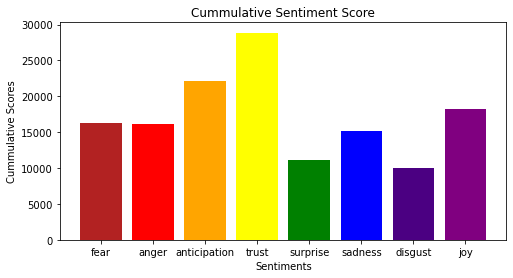

In [47]:
import matplotlib.pyplot as plt 
import seaborn as sns

fear = sum(data['fear'])
anger = sum(data['anger'])
anticipation = sum(data['anticipation'])
trust = sum(data['trust'])
surprise = sum(data['surprise'])
sadness = sum(data['sadness'])
disgust = sum(data['disgust'])
joy = sum(data['joy'])

sentiments = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'disgust', 'joy']
scores = [fear, anger, anticipation, trust, surprise, sadness, disgust, joy]
colors = ['firebrick', 'red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'purple']


plt.figure(figsize=(8, 4))
plt.bar(sentiments, scores, color=colors)

# Adding titles and labels
plt.title('Cummulative Sentiment Score')
plt.xlabel('Sentiments')
plt.ylabel('Cummulative Scores')

Text(0, 0.5, 'Mean Scores')

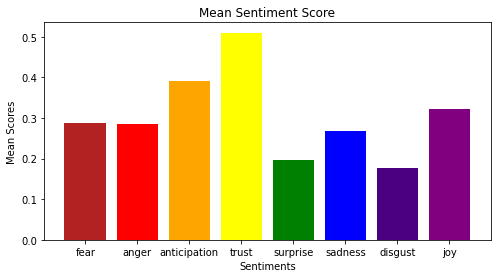

In [49]:
mean = [fear/56571, anger/56571, 
        anticipation/56571, 
        trust/56571, surprise/56571, 
        sadness/56571, disgust/56571, 
        joy/56571]

plt.figure(figsize=(8, 4))
plt.bar(sentiments, mean, color=colors)

# Adding titles and labels
plt.title('Mean Sentiment Score')
plt.xlabel('Sentiments')
plt.ylabel('Mean Scores')

C:\Users\RY-LU\AppData\Local\Temp/ipykernel_16164/3842680803.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['dummy'] = 1


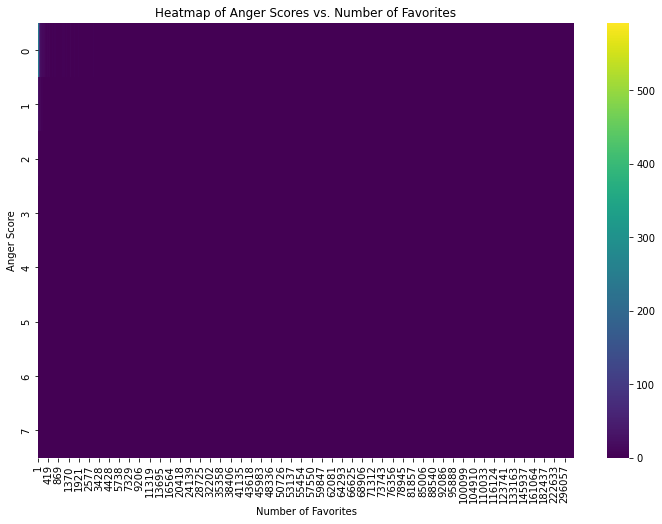

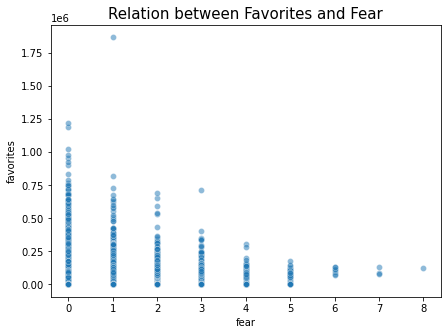

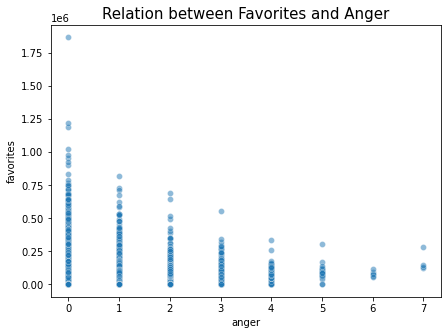

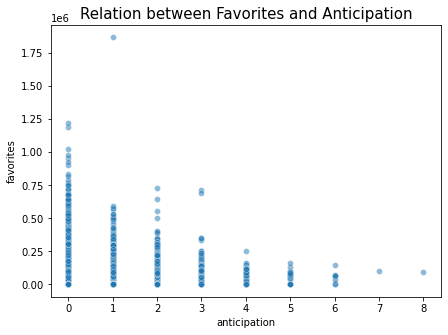

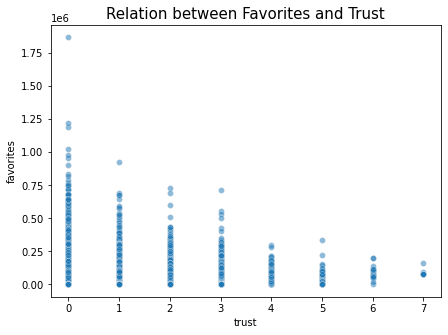

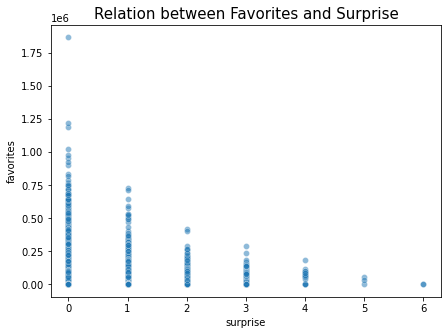

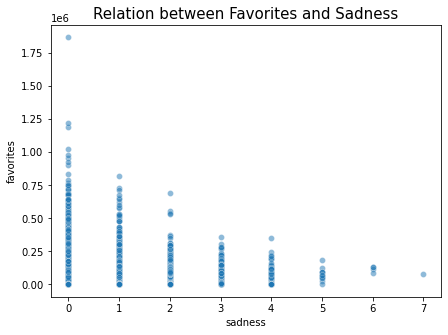

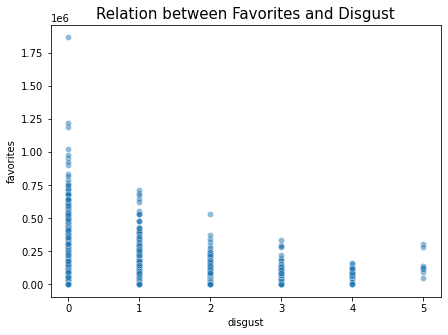

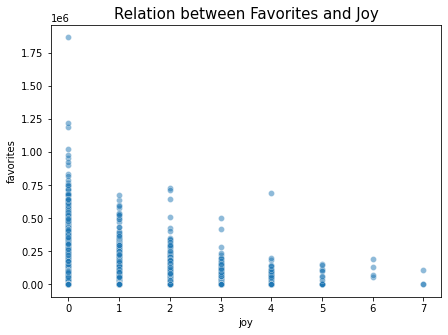

In [56]:
temp = data[data['anger'] > 0]
temp = data[data['favorites'] > 0]

temp['dummy'] = 1
pivot_table = temp.pivot_table(values='dummy', index='anger', columns='favorites', aggfunc='count', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=False, cmap='viridis')  # You can change the colormap as needed
plt.title('Heatmap of Anger Scores vs. Number of Favorites')
plt.xlabel('Number of Favorites')
plt.ylabel('Anger Score')

plt.figure(figsize=(7,5))
sns.scatterplot(data = data, x = "fear", y = "favorites", alpha = 0.5)
plt.title("Relation between Favorites and Fear", fontsize = 15)
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data = data, x = "anger", y = "favorites", alpha = 0.5)
plt.title("Relation between Favorites and Anger", fontsize = 15)
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data = data, x = "anticipation", y = "favorites", alpha = 0.5)
plt.title("Relation between Favorites and Anticipation", fontsize = 15)
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data = data, x = "trust", y = "favorites", alpha = 0.5)
plt.title("Relation between Favorites and Trust", fontsize = 15)
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data = data, x = "surprise", y = "favorites", alpha = 0.5)
plt.title("Relation between Favorites and Surprise", fontsize = 15)
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data = data, x = "sadness", y = "favorites", alpha = 0.5)
plt.title("Relation between Favorites and Sadness", fontsize = 15)
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data = data, x = "disgust", y = "favorites", alpha = 0.5)
plt.title("Relation between Favorites and Disgust", fontsize = 15)
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data = data, x = "joy", y = "favorites", alpha = 0.5)
plt.title("Relation between Favorites and Joy", fontsize = 15)
plt.show()